# Label numériques des écoles
## Exploration des données

On charge d'abord les différentes librairies qui nous seront utiles pour manipuler les données

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import plotly.express as px

In [3]:
dataset = pd.read_csv("../data/ecole/csv/fr-en-occitanie-ac-montpellier-label-numerique-ecoles.csv", sep=";")

#Renommage des colonnes
old_columns_names = dataset.columns.values
new_columns_names = {}

for old_name in old_columns_names:
    new_name = old_name.replace(" ", "_").lower()
    new_columns_names[old_name] = new_name

dataset = dataset.rename(columns=new_columns_names)

#Changer les indexs pour avoir une colonne "id" qui servira pour de futures jointures

dataset = dataset.set_index("uai")

#Transformer la colonne position en 2 colonnes latitude et longitude
dataset[["latitude", "longitude"]] = dataset["position"].str.split(",", expand=True)
dataset = dataset.drop(columns=["position"])


#Remplacer le nom de l'école par le nom de l'ecole plus le type, d'école et si c'est public ou privé
#Supprimer ce qui est inutile dans école


def transform(row):
    libelle_ecole = row.ecole.split(" ", 2)
    row["niveau"] = libelle_ecole[1].lower()
    nom_ecole = libelle_ecole[2].lower()
    second_split_try = nom_ecole.split(" ", 1)
    #On vérifie si ce qu'on a après le split est bien publique ou juste le nom de l'école
    if(second_split_try[0] == "publique"):
        #On verifie si on peut bien split, c'est a dire qu'on a plus que juste le mot publique ou bien chose après
        if(len(second_split_try) >= 2):
            nom_ecole = second_split_try[1]
        else:
            nom_ecole = "non renseigné"
    
    row["nom_ecole"] = nom_ecole
    return row
        
        
dataset = dataset.apply(lambda row: transform(row), axis=1)
#dataset = dataset.drop(columns=["ecole"])

dataset.niveau_label.astype("int64")

uai
0110161R    1
0110173D    1
0110256U    1
0300473B    1
0300632Z    1
           ..
0110427E    3
0301351F    3
0340803N    3
0480253P    3
0660393U    3
Name: niveau_label, Length: 155, dtype: int64

On va commencer par voir les différentes colonnes qui existent

In [4]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, 0110161R to 0660393U
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   niveau_label  155 non-null    int64  
 1   commune       155 non-null    object 
 2   ecole         155 non-null    object 
 3   nbr_classes   155 non-null    float64
 4   latitude      155 non-null    object 
 5   longitude     155 non-null    object 
 6   niveau        155 non-null    object 
 7   nom_ecole     155 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 15.0+ KB
None


On va voir ensuite quels sont les proportions des différents labels

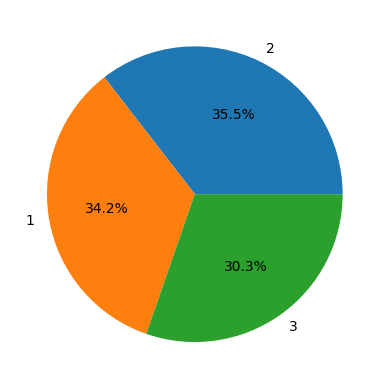

In [5]:
sizes = dataset.niveau_label.value_counts()

plt.pie(sizes, labels=sizes.index.values, autopct='%1.1f%%')
plt.show()

- On peut voir qu'il y a une répartition assez équilibrée des labels. On voit quand même un tiers des écoles qui ont un label ont un label de niveau 3
- Il faudrait penser à comparer avec le nombre total d'écoles sur l'occitanie pour voir si ce pourcentage est élevé ou pas

On va maintenant s'intéresser à quel niveau on a le plus d'établissement engagés dans ces démarches

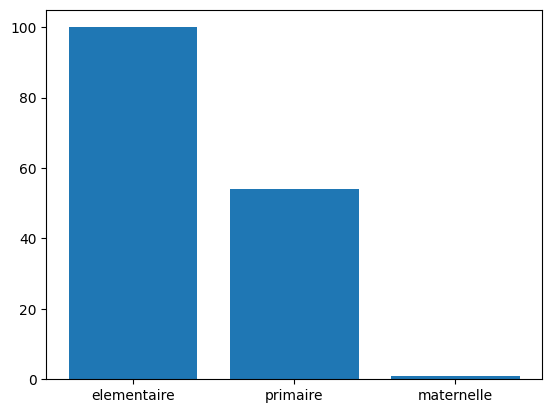

In [6]:
ecoles = dataset.niveau.value_counts()
y_pos = range(len(ecoles.index.values))

plt.bar(y_pos, ecoles.values)
plt.xticks(y_pos, ecoles.index.values)
plt.show()

On peut voir qu'il y a une minorité d'école maternelle.

In [7]:
print(dataset.loc[dataset.niveau == "maternelle"].niveau.count())

1


On voit bien qu'il n'y a qu'une seule école maternelle à avoir un label numérique.
Seul soucis : 
  - C'est qu'on a quand même un grand nombre d'écoles pour lesquelles on ne sait pas si c'est du élémentaire ou de la maternelle

In [8]:
m = folium.Map(location=[float(dataset.latitude[0]), float(dataset.longitude[0])], zoom_start=12, tiles="Stamen Terrain", height=500, width="100%")

for i in range(len(dataset)):
    color = "green" if dataset.niveau[i] == "maternelle" else "blue" if dataset.niveau[i] == "primaire" else "red"
    folium.Marker([float(dataset.latitude[i]), float(dataset.longitude[i])], popup=dataset.ecole[i], tooltip="See school", icon=folium.Icon(color = color, icon="school", prefix="fa")).add_to(m)

m

On va essayer de voir si il existe des liens entre les différentes variables. pour cela, on utilise la matrice de corrélation pour les variables numériques, qui sont le nombre de classe et le label numérique.

              niveau_label  nbr_classes
niveau_label      1.000000    -0.268604
nbr_classes      -0.268604     1.000000


<AxesSubplot:xlabel='nbr_classes', ylabel='niveau_label'>

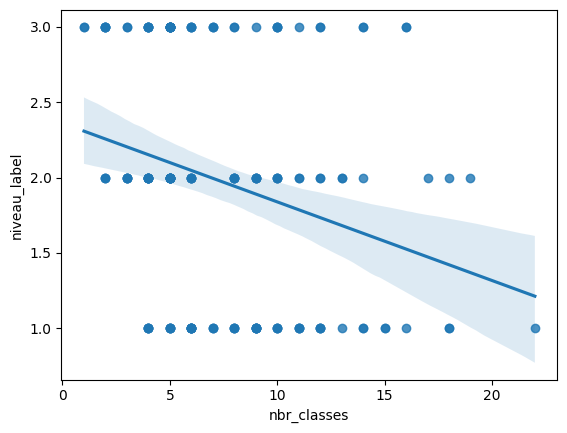

In [9]:
corr_matrix = dataset.corr()
print(corr_matrix)

sns.regplot(data=dataset, x="nbr_classes", y="niveau_label")

On voit qu'il n'y a absolument aucun lien entre le nombre de classes et le label

array([[<AxesSubplot:xlabel='niveau_label', ylabel='niveau_label'>,
        <AxesSubplot:xlabel='nbr_classes', ylabel='niveau_label'>],
       [<AxesSubplot:xlabel='niveau_label', ylabel='nbr_classes'>,
        <AxesSubplot:xlabel='nbr_classes', ylabel='nbr_classes'>]],
      dtype=object)

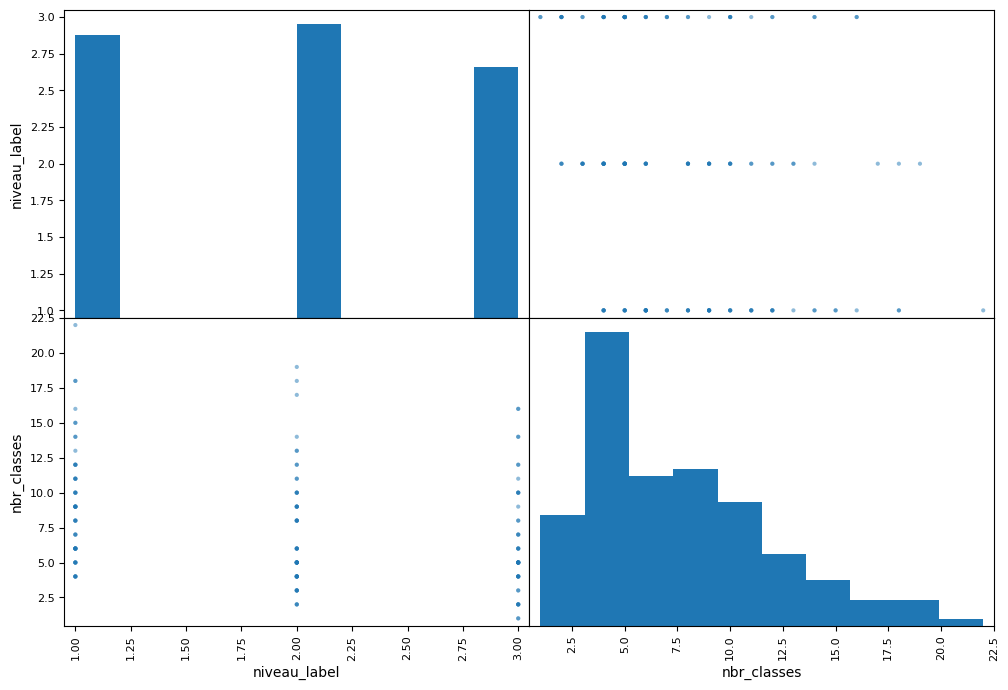

In [10]:
from pandas.plotting import scatter_matrix

scatter_matrix(dataset, figsize=(12, 8))

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
from sklearn.decomposition import FactorAnalysis

transformer = FactorAnalysis(n_components=7, random_state=0)


## Un deuxième jeu de données

On récupére le jeu de données recu sur les TNE pour l'explorer et voir ce qu'il contient

In [13]:
dataset2 = pd.read_excel("../data/ecole/csv/Etablissements-scolaires-du-TNE-34.xlsx")

#Affectation des bons noms de colonnes
column_names = dataset2.loc[1]
dataset2 = dataset2.loc[2:]
dataset2 = dataset2.rename(columns=column_names)

print(dataset2.shape)
print(dataset2.columns.values)

(37, 3)
['Communes' 'Nom' 'UAI']


Ce jeu de données ne contient rien d'intéressant

## Un troisième jeu de données

Ce jeu de données contient les IPS des différentes écoles

In [14]:
#Récupération du jeu de données
dataset_ips = pd.read_csv("../data/ecole/csv/fr-en-ips_ecoles.csv", sep=";")

#Nettoyage des données

new_columns_names = {"UAI": "uai", "Rentrée scolaire":"annee", "Académie": "academie", "Code du département": "code_depart", "Département" : "departement", "Secteur":"secteur", "IPS":"ips"}

dataset_ips.rename(columns=new_columns_names, inplace=True)
dataset_ips = dataset_ips.set_index("uai")

dataset_ips = dataset_ips.drop(columns=["Code INSEE de la commune", "Nom de la commune", "Nom de l'établissment", "Code INSEE de la commune"])

dataset.drop(columns=["ecole", "nom_ecole"])


#Jointure des 2 datasets

join = dataset.join(dataset_ips, how="right", lsuffix="_ecole", rsuffix="_ips", on="uai")

#On supprime les lignes qui n'ont pas de niveau
join = join.loc[pd.notna(join.niveau_label)]


On va chercher si il y a une corrélation entre l'IPS et le Niveau label

              niveau_label  nbr_classes       ips
niveau_label      1.000000    -0.266718  0.135109
nbr_classes      -0.266718     1.000000 -0.411166
ips               0.135109    -0.411166  1.000000


array([[<AxesSubplot:xlabel='niveau_label', ylabel='niveau_label'>,
        <AxesSubplot:xlabel='nbr_classes', ylabel='niveau_label'>,
        <AxesSubplot:xlabel='ips', ylabel='niveau_label'>],
       [<AxesSubplot:xlabel='niveau_label', ylabel='nbr_classes'>,
        <AxesSubplot:xlabel='nbr_classes', ylabel='nbr_classes'>,
        <AxesSubplot:xlabel='ips', ylabel='nbr_classes'>],
       [<AxesSubplot:xlabel='niveau_label', ylabel='ips'>,
        <AxesSubplot:xlabel='nbr_classes', ylabel='ips'>,
        <AxesSubplot:xlabel='ips', ylabel='ips'>]], dtype=object)

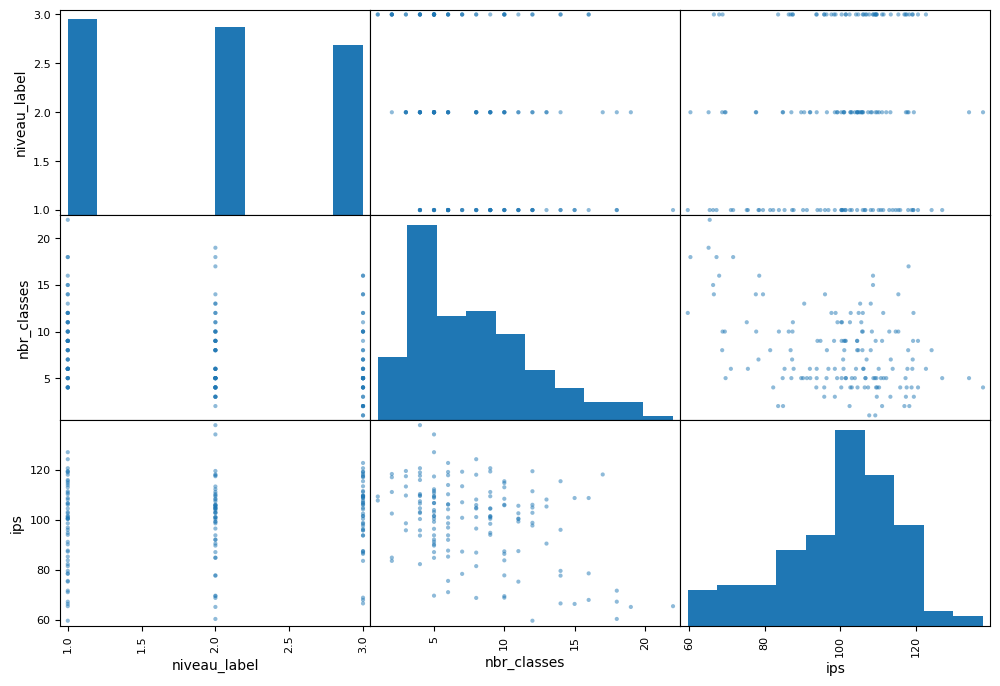

In [15]:
corr_matrix = join.corr()

print(corr_matrix)

scatter_matrix(join, figsize=(12, 8))

In [16]:
print(join.niveau_label.dtype)
print(join.ips.dtype)
join.latitude = join.latitude.astype("float64")
join.longitude = join.longitude.astype("float64")
join.niveau_label = join.niveau_label.astype("int64")
print(join.latitude.dtype)

float64
float64
float64


In [17]:
fig = px.scatter_mapbox(join, lat="latitude", lon="longitude", 
            color="niveau_label" ,size="ips" , color_continuous_scale=px.colors.diverging.Spectral_r, 
            hover_name="ecole", zoom=10, height=300)
fig.show()

Les données ne sont pas trop exploitables. On va chercher une autre source de données qui est celle sur les enquêtes ETIC